In [2]:
import os,sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import h5py
from datetime import datetime
from tqdm import tqdm

from multiprocessing import Pool
from functools  import partial

import shapely
from shapely.geometry import Point, Polygon
import geopandas as gpd


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


merged_dir = '/raid60/scratch/leo/scratch/converted_v5'
des_dir    = '/raid60/scratch/federico/DESROZIERS_01APRIL_onlygroup'  # directory with 

def get_data(file_name , complete = False, var = 85 , plev = 92500 ):
    """ Simple script to extract only the most relevant data out of a netCDF file using h5py.
        One variable per one plevel at a time.
        If complete, it means that the file is the final version.
        Otherwise, I use both the merged and the desrozier partial files. """
    
    
    file_merged = merged_dir + '/' + file_name.replace('_uncertanty','')
    file_des = des_dir + '/' + file_name
    f =  h5py.File(file_merged, 'r')
    
    lat, lon = f['observations_table']['latitude'][0] , f['observations_table']['longitude'][0]
    
    res = {} # dic to convert to dataframe 

    if str(var) not in  f['recordindices'].keys():
        return lat,lon, None
    
    indices = f['recordindices'][str(var)]
    imin, imax = min(indices) , max(indices) # I miss here the last entr since I would need the exact index 

    ind_all = np.array([])
    a = np.where(f['observations_table']['z_coordinate'][imin:imax] == plev)[0]
    ind_all = np.append(ind_all, a)


    obs_vars = ['date_time', 'observation_value', 'observed_variable', 'z_coordinate' ]
    fb_vars  = ['biascorr@body' , 'an_depar@body', 'fg_depar@body' ]
    
    ind_all = list(ind_all)

    for c in obs_vars:
        res[c] = np.take(f['observations_table'][c][imin:imax], ind_all )

    for c in fb_vars:
        res[c] = np.take(f['era5fb'][c][imin:imax], ind_all )

    if complete: 
        for c in f['advanced_uncertainty'].keys():
            res[c] = np.take(f['advanced_uncertainty'][c][imin:imax], ind_all )

    else:
        f_des = h5py.File(file_des, 'r')
        for c in f_des['advanced_uncertainty'].keys():
            res[c] = np.take(f_des['advanced_uncertainty'][c][imin:imax], ind_all )

    dfs = pd.DataFrame.from_dict(res)
        
    return lat, lon, dfs 



def calc_average(df, years = [2000,2020] ):
    """ calculate average (pressure level and variables are already pre-selected) """
    
    if not df.empty:
        
    
        y1, y2= (years[0]-1900)*365.25*24*3600 , (years[1]-1900)*365.25*24*3600  # converting to seconds after 1900 as in the merged files
        
        ind_y = np.where( (df['date_time'] >= y1 ) & (df['date_time'] <= y2 ) )[0]
        av_30 = np.nanmean( df['desroziers_30'][ind_y] )
        av_60 = np.nanmean( df['desroziers_60'][ind_y] )
        av_90 = np.nanmean( df['desroziers_90'][ind_y] )
        av_180 = np.nanmean( df['desroziers_180'][ind_y] )

    else:
        av_30, av_60, av_90, av_180 = np.nan, np.nan, np.nan, np.nan
        
    return av_30, av_60, av_90, av_180

    

def extract_average(complete, var, plev, years, file_name ):
        
    lat, lon, df = get_data(file_name , complete = complete, var = var , plev = plev )
    if isinstance(df, pd.DataFrame):
        av_30, av_60, av_90, av_180 = calc_average(df, years = years)
    else:
        av_30, av_60, av_90, av_180 = np.nan , np.nan, np.nan , np.nan
    
    return {'lat':lat, 'lon':lon, 'av_30':av_30, 'av_60':av_60, 'av_90':av_90 , 'av_180': av_180 }
    

    
""" Plotting part """
def loading_WMO_regions_gpd():
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')
    return WMO

def station_plot(data='', years = [], variable = '', plev = ''):
    # https://stackoverflow.com/questions/59417997/how-to-plot-a-list-of-shapely-points                                                                                                                                                                                                   
    
    def clean_data(latitude,longitude,uncert):
        lat,lon,unc = [],[],[]
        for la,lo,un in zip(latitude,longitude,uncert):
            if not np.isnan(un):
                lat.append(la)
                lon.append(lo)
                unc.append(un)
        return lat,lon,unc
            
            
    """ Cleaning the data """
    for u in ['av_30', 'av_60', 'av_90', 'av_180'] :
        
        """ Geopandas modules """
        WMO = loading_WMO_regions_gpd()
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        world = world.plot()
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        world = world.plot()
        WMO.plot( ax=world,  facecolor="none", edgecolor="lightgray", lw = 0.8)
        
        """ Cleaning data """
        lat, lon, unc = data['lat'], data['lon'], data[u]
        lat, lon, unc = clean_data(lat,lon,unc)

        plotto = plt.scatter( lon, lat , c= unc,  s = 0.7, cmap='cool' )
        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar
        plt.clim(0, 3)
        var_name = { 85 : 'Temperature [K] '        ,
                    104 : 'Wind u-component [m/s]'  ,
                    105 : 'Wind v-component [m/s] ' ,
                    107 : 'Wind Speed [m/s] '        }
        
        cbar.set_label('Error ' + var_name[var])
        window = u.split('_')[1]
        
        plt.title ('Mean Desroziers ' + window + ' days ' + ' Uncertainty ['  + str(years[0]) + ',' + str(years[1]) + ']' + ' plev= ' + str(plev) , fontsize = 9)

        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])

        #plt.legend(loc = 'lower left', fontsize = 6 ,ncol = 2)
        plt.savefig('Plots/uncertainty_location_' + str(years[0]) + '_' + str(variable) + '_' + str(plev) + '_' + u + '.png', dpi= 250,   bbox_inches = 'tight' )
        plt.show()
        plt.close()
        
        
        
    
   

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Loading existing data frame *** 


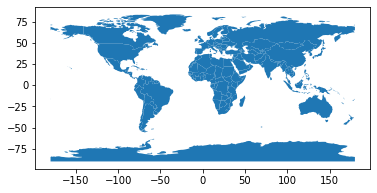

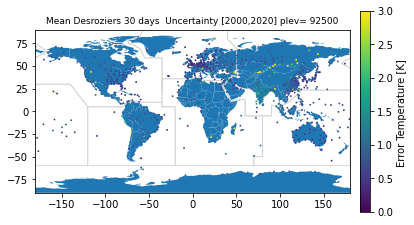

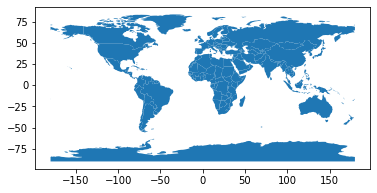

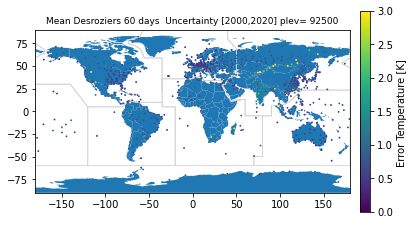

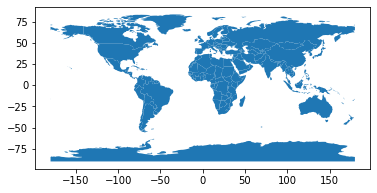

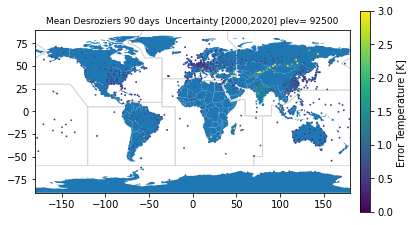

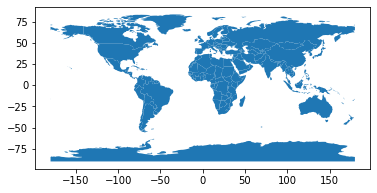

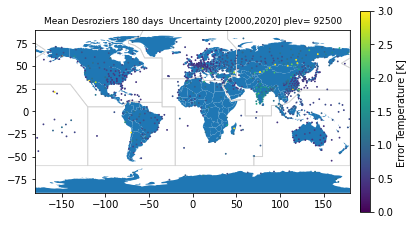

In [3]:
""" Running, settiman main parameters s"""
files = os.listdir(des_dir)


var = 85
years = [2000,2020]
plev = 92500 
complete = False 
POOL = True

for var in [85] :
    for p in [10000]:
        
        file_name = str(var) + '_' + str(plev) + '_' + str(years[0]) + '.npy'
        
        if os.path.isfile (file_name):
            print('Loading existing data frame *** ')
            res_df = pd.read_pickle(file_name)
            
        else:
            print('Creating data frame *** ')
            
            if POOL:
                p = Pool(30)
                func = partial(extract_average, complete, var , plev , years )
                out = p.map(func, files) 
                res_df = pd.DataFrame.from_dict(out)
                res_df.to_pickle(file_name)
                
            
            else:
                dic_list = []
                for f in tqdm(files):
                    dic = extract_average(complete, var, plev, years, f )
                    dic_list.append(dic)
                    
                res = { 'lat': [d['lat'] for d in dic_list ] ,
                        'lon': [d['lon'] for d in dic_list ] ,
                        'av_30': [d['av_30'] for d in dic_list ] , }        
                
                res_df = pd.DataFrame.from_dict(res)
                res_df.to_pickle(file_name)
                
        
        a = station_plot(data= res_df, years = years, variable = var, plev = plev)
    